In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#imports
import pandas as pd
import numpy as np
import random


In [4]:
#define stress Lables

stress_labels = ["Low", "Moderate", "High"]

In [5]:
#self- reflective texts

# Base templates for reflective texts
low_templates = [
    "I am feeling calm and confident while completing my {aspect}.",
    "This week, I managed my {aspect} smoothly without any stress.",
    "I am satisfied with my progress in {aspect} and feel relaxed.",
    "Balancing my {aspect} along with personal time is going well.",
    "I feel positive about my {aspect} and upcoming tasks."
]

moderate_templates = [
    "I feel a bit stressed about managing my {aspect} on time.",
    "The {aspect} workload is increasing, causing mild anxiety.",
    "I am trying to stay on top of my {aspect}, but it feels challenging.",
    "Sometimes I worry about finishing my {aspect} before deadlines.",
    "I feel some pressure while balancing {aspect} with other responsibilities."
]

high_templates = [
    "I feel overwhelmed by my {aspect} and struggle to cope with deadlines.",
    "The stress from {aspect} is affecting my focus and mental well-being.",
    "I am panicked about completing my {aspect} and feel anxious constantly.",
    "Managing my {aspect} feels impossible and I am extremely stressed.",
    "I am frustrated and worried that I cannot keep up with my {aspect} workload."
]

# Word banks
aspects = ["assignments", "projects", "coursework", "exams", "academic work"]



In [6]:
#function to generate texts

def generate_text(templates, n):
    texts = []
    for _ in range(n):
        template = random.choice(templates)
        text = template.format(
            aspect=random.choice(aspects)
        )
        texts.append(text)
    return texts

# generate dataset
low_stress_texts = generate_text(low_templates, 100)
moderate_stress_texts = generate_text(moderate_templates, 100)
high_stress_texts = generate_text(high_templates, 100)

#combine all texts with lables
data = []
for text in low_stress_texts:
    data.append([text, "Low"])
for text in moderate_stress_texts:
    data.append([text, "Moderate"])
for text in high_stress_texts:
    data.append([text, "High"])

#create dataFrame and shuffle
df = pd.DataFrame(data, columns=["text", "label"])
df = df.sample(frac=1).reset_index(drop=True)

#save CSV
df.to_csv("academic_stress_reflections.csv", index=False)

#review
print("Dataset shape:", df.shape)
print(df.head())
print("\nLabel distribution:\n", df["label"].value_counts())


Dataset shape: (300, 2)
                                                text label
0  I am feeling calm and confident while completi...   Low
1  I feel positive about my coursework and upcomi...   Low
2  I feel positive about my academic work and upc...   Low
3  I am frustrated and worried that I cannot keep...  High
4  I feel positive about my academic work and upc...   Low

Label distribution:
 label
Low         100
High        100
Moderate    100
Name: count, dtype: int64


In [7]:
#label encoding

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print(df.head())


                                                text label  label_encoded
0  I am feeling calm and confident while completi...   Low              1
1  I feel positive about my coursework and upcomi...   Low              1
2  I feel positive about my academic work and upc...   Low              1
3  I am frustrated and worried that I cannot keep...  High              0
4  I feel positive about my academic work and upc...   Low              1


In [8]:
#tokenization and vocabulary

from collections import Counter

# simple tokenizer: lowercase + split
def tokenize(text):
    return text.lower().split()

# build vocabulary
counter = Counter()
for text in df['text']:
    counter.update(tokenize(text))

# create word-to-index mapping
vocab = {word: idx+2 for idx, (word, _) in enumerate(counter.items())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1  # unknown token
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)


Vocabulary size: 104


In [9]:
#encode text to integers
def encode(text):
    return [vocab.get(word, 1) for word in tokenize(text)]

df['encoded_text'] = df['text'].apply(encode)
print(df.head())


                                                text label  label_encoded  \
0  I am feeling calm and confident while completi...   Low              1   
1  I feel positive about my coursework and upcomi...   Low              1   
2  I feel positive about my academic work and upc...   Low              1   
3  I am frustrated and worried that I cannot keep...  High              0   
4  I feel positive about my academic work and upc...   Low              1   

                                        encoded_text  
0                   [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  
1                 [2, 12, 13, 14, 10, 15, 6, 16, 17]  
2             [2, 12, 13, 14, 10, 18, 19, 6, 16, 17]  
3  [2, 3, 20, 6, 21, 22, 2, 23, 24, 25, 26, 10, 1...  
4             [2, 12, 13, 14, 10, 18, 19, 6, 16, 17]  


In [10]:
#train/test split

from sklearn.model_selection import train_test_split

#split 60% train, and 40% temp
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['encoded_text'],
    df['label_encoded'],
    test_size=0.4, #40% goes to temp
    random_state=42,
    stratify=df['label_encoded']
)

# split temp into validation 20% and Test 20%
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5, #half of 40% -> 20% test and 20% val
    stratify=temp_labels,
    random_state=42
)

print("Training samples:", len(train_texts))
print("Validation samples:", len(val_texts))
print("Testing samples:", len(test_texts))

Training samples: 180
Validation samples: 60
Testing samples: 60


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

#custom dataset
class StressDataset(Dataset):
    def __init__(self, texts, labels):
        # Convert each text (list of integers) to torch tensor
        self.texts = [torch.tensor(t, dtype=torch.long) for t in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

#collect function for dataloader(padding)
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return texts_padded, labels

In [12]:
#dataset and dataloader

# Custom Dataset remains the same
train_dataset = StressDataset(train_texts.tolist(), train_labels.tolist())
val_dataset   = StressDataset(val_texts.tolist(), val_labels.tolist())
test_dataset  = StressDataset(test_texts.tolist(), test_labels.tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Quick check
for x, y in train_loader:
    print("Batch X shape:", x.shape)
    print("Batch Y:", y)
    break



Batch X shape: torch.Size([16, 15])
Batch Y: tensor([0, 2, 1, 2, 0, 0, 2, 0, 1, 0, 1, 0, 2, 1, 1, 2])


In [13]:
#quick check of training batch
for x, y in train_loader:
    print("Training Batch X shape:", x.shape)
    print("Training Batch Y:", y)
    break

#quick check of testing batch
for x, y in test_loader:
    print("Testing Batch X shape:", x.shape)
    print("Testing Batch Y:", y)
    break



Training Batch X shape: torch.Size([16, 14])
Training Batch Y: tensor([2, 2, 2, 2, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0])
Testing Batch X shape: torch.Size([16, 14])
Testing Batch Y: tensor([0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2])


In [14]:
#imports
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import classification_report

#LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

#Bi-LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        # Concatenate forward and backward hidden states
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        out = self.fc(hidden_cat)
        return out


In [15]:

#device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [16]:
from torch.nn import CrossEntropyLoss

#initialize model (LSTM)
model = LSTMModel(vocab_size=vocab_size, embed_dim=64, hidden_dim=64, output_dim=3)
model = model.to(device)

#loss and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [17]:
#LSTM training loop with validation

lstm_losses = []
lstm_val_losses = []

epochs = 30
for epoch in range(epochs):
    #train
    model.train()
    total_train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    lstm_losses.append(avg_train_loss)

    #validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    lstm_val_losses.append(avg_val_loss)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}"
    )

Epoch 1/30 | Train Loss: 1.0630 | Val Loss: 1.0334
Epoch 2/30 | Train Loss: 0.9614 | Val Loss: 0.9331
Epoch 3/30 | Train Loss: 0.8147 | Val Loss: 0.7123
Epoch 4/30 | Train Loss: 0.5172 | Val Loss: 0.3558
Epoch 5/30 | Train Loss: 0.2083 | Val Loss: 0.1112
Epoch 6/30 | Train Loss: 0.0569 | Val Loss: 0.0452
Epoch 7/30 | Train Loss: 0.0222 | Val Loss: 0.0221
Epoch 8/30 | Train Loss: 0.0129 | Val Loss: 0.0150
Epoch 9/30 | Train Loss: 0.0097 | Val Loss: 0.0115
Epoch 10/30 | Train Loss: 0.0079 | Val Loss: 0.0088
Epoch 11/30 | Train Loss: 0.0062 | Val Loss: 0.0073
Epoch 12/30 | Train Loss: 0.0061 | Val Loss: 0.0062
Epoch 13/30 | Train Loss: 0.0043 | Val Loss: 0.0055
Epoch 14/30 | Train Loss: 0.0039 | Val Loss: 0.0049
Epoch 15/30 | Train Loss: 0.0035 | Val Loss: 0.0044
Epoch 16/30 | Train Loss: 0.0034 | Val Loss: 0.0040
Epoch 17/30 | Train Loss: 0.0029 | Val Loss: 0.0036
Epoch 18/30 | Train Loss: 0.0027 | Val Loss: 0.0033
Epoch 19/30 | Train Loss: 0.0025 | Val Loss: 0.0030
Epoch 20/30 | Train L

In [18]:
#evaluation

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(x_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu().numpy())

# Classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Classification Report:

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        20
         Low       1.00      1.00      1.00        20
    Moderate       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



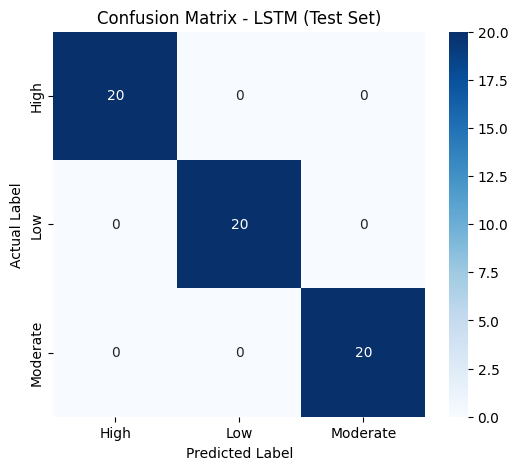

In [19]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - LSTM (Test Set)")
plt.show()


In [20]:
#inference time for text data
import time
import numpy as np

times = []

model.eval()
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        start = time.time()
        _ = model(x_batch)  # forward pass
        end = time.time()

        # time per sample in the batch
        times.append((end - start) / x_batch.size(0))

print(f"Average inference time per text sample: {np.mean(times)*1000:.4f} ms")


Average inference time per text sample: 0.0503 ms


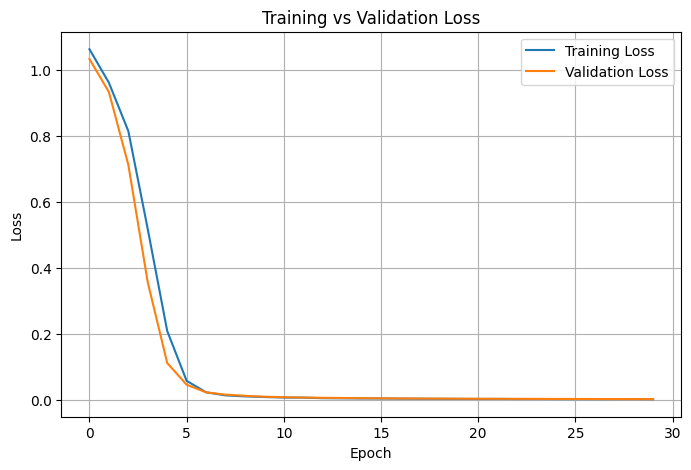

In [21]:
#training and validation loss curve
plt.figure(figsize=(8,5))
plt.plot(lstm_losses, label="Training Loss")
plt.plot(lstm_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
#saving the model
torch.save(model.state_dict(), "lstm_stress_model.pth")
print("Model saved successfully!")


Model saved successfully!


In [23]:
#Bi-LSTM initialization

bi_model = BiLSTMModel(vocab_size=vocab_size, embed_dim=64, hidden_dim=64, output_dim=3)
bi_model = bi_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(bi_model.parameters(), lr=0.001)

In [24]:
#Bi-LSTM training with validation
bilstm_losses = []
bilstm_val_losses = []

epochs = 30  # keeping same as LSTM for fair comparison

for epoch in range(epochs):
    #training
    bi_model.train()
    total_train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = bi_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    bilstm_losses.append(avg_train_loss)

    #validation
    bi_model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = bi_model(x_val)
            loss = criterion(outputs, y_val)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    bilstm_val_losses.append(avg_val_loss)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}"
    )



Epoch 1/30 | Train Loss: 1.0366 | Val Loss: 0.9645
Epoch 2/30 | Train Loss: 0.8703 | Val Loss: 0.7787
Epoch 3/30 | Train Loss: 0.6071 | Val Loss: 0.4757
Epoch 4/30 | Train Loss: 0.2704 | Val Loss: 0.1301
Epoch 5/30 | Train Loss: 0.0564 | Val Loss: 0.0223
Epoch 6/30 | Train Loss: 0.0104 | Val Loss: 0.0078
Epoch 7/30 | Train Loss: 0.0045 | Val Loss: 0.0046
Epoch 8/30 | Train Loss: 0.0029 | Val Loss: 0.0034
Epoch 9/30 | Train Loss: 0.0023 | Val Loss: 0.0029
Epoch 10/30 | Train Loss: 0.0022 | Val Loss: 0.0024
Epoch 11/30 | Train Loss: 0.0017 | Val Loss: 0.0021
Epoch 12/30 | Train Loss: 0.0015 | Val Loss: 0.0019
Epoch 13/30 | Train Loss: 0.0014 | Val Loss: 0.0017
Epoch 14/30 | Train Loss: 0.0011 | Val Loss: 0.0015
Epoch 15/30 | Train Loss: 0.0010 | Val Loss: 0.0014
Epoch 16/30 | Train Loss: 0.0009 | Val Loss: 0.0013
Epoch 17/30 | Train Loss: 0.0008 | Val Loss: 0.0012
Epoch 18/30 | Train Loss: 0.0008 | Val Loss: 0.0011
Epoch 19/30 | Train Loss: 0.0008 | Val Loss: 0.0010
Epoch 20/30 | Train L

In [25]:
#evaluate Bi-LSTM on Test Set

bi_model.eval()
bi_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = bi_model(x_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        bi_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

#classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("\nBi-LSTM Classification Report (Test Set):\n")
print(classification_report(all_labels, bi_preds, target_names=label_encoder.classes_))




Bi-LSTM Classification Report (Test Set):

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        20
         Low       1.00      1.00      1.00        20
    Moderate       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



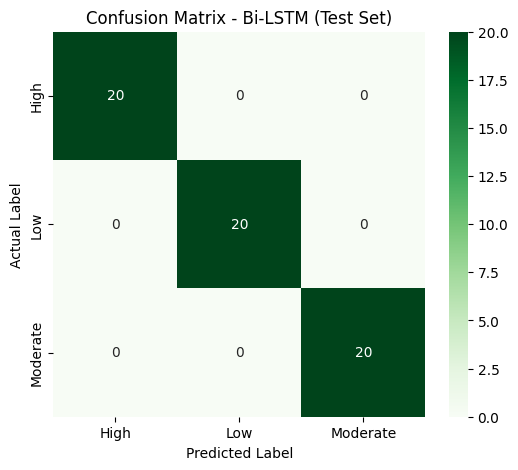

In [26]:

#confusion Matrix
cm = confusion_matrix(all_labels, bi_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Greens')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Bi-LSTM (Test Set)")
plt.show()

In [27]:
#comparision : LSTM vs Bi-LSTM

from sklearn.metrics import accuracy_score, f1_score

#LSTM metrics
lstm_acc = accuracy_score(all_labels, all_preds)
lstm_f1 = f1_score(all_labels, all_preds, average='macro')

#Bi-LSTM metrics
bi_acc = accuracy_score(all_labels, bi_preds)
bi_f1 = f1_score(all_labels, bi_preds, average='macro')

import pandas as pd
comparison_df = pd.DataFrame({
    "Model": ["LSTM", "Bi-LSTM"],
    "Accuracy": [lstm_acc, bi_acc],
    "F1-Score": [lstm_f1, bi_f1]
})

print("\nLSTM vs Bi-LSTM Performance:\n")
print(comparison_df)



LSTM vs Bi-LSTM Performance:

     Model  Accuracy  F1-Score
0     LSTM       1.0       1.0
1  Bi-LSTM       1.0       1.0


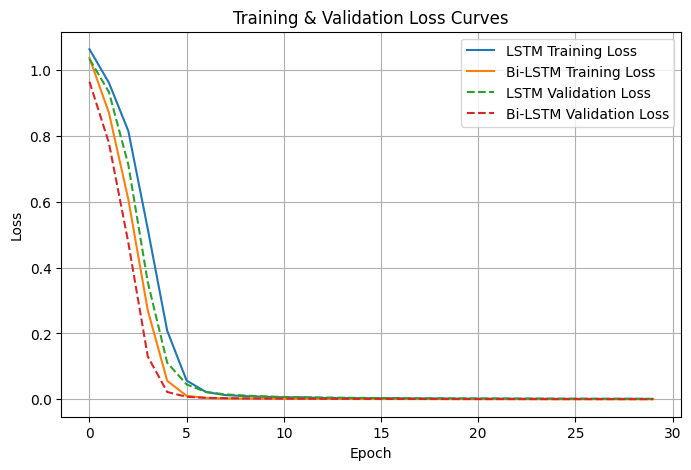

In [28]:
#plot loss curves
plt.figure(figsize=(8,5))
plt.plot(lstm_losses, label="LSTM Training Loss")
plt.plot(bilstm_losses, label="Bi-LSTM Training Loss")
plt.plot(lstm_val_losses, label="LSTM Validation Loss", linestyle='--')
plt.plot(bilstm_val_losses, label="Bi-LSTM Validation Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


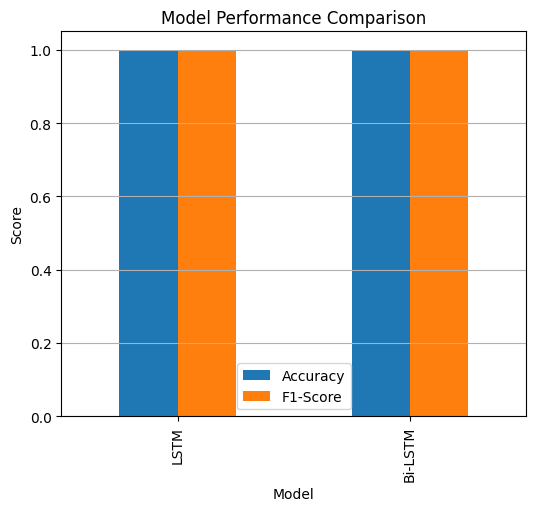

In [29]:
#bar chart of accuract and F1-score
metrics_df = pd.DataFrame({
    "Model": ["LSTM", "Bi-LSTM"],
    "Accuracy": [lstm_acc, bi_acc],
    "F1-Score": [lstm_f1, bi_f1]
})

metrics_df.set_index("Model").plot(kind="bar", figsize=(6,5))
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.ylim(0,1.05)
plt.grid(axis='y')
plt.show()


In [40]:
%cd /content/drive/MyDrive/College/Msc IT/SEM - 3/Neural Network and Deep Learning/Coursework/Academic Stress detection


/content/drive/MyDrive/College/Msc IT/SEM - 3/Neural Network and Deep Learning/Coursework/Academic Stress detection


In [43]:
%cd "/content/drive/MyDrive/College/Msc IT/SEM - 3/Neural Network and Deep Learning/Coursework/Academic Stress detection/Academic-stress-detection"
!pwd


/content/drive/MyDrive/College/Msc IT/SEM - 3/Neural Network and Deep Learning/Coursework/Academic Stress detection/Academic-stress-detection
/content/drive/MyDrive/College/Msc IT/SEM - 3/Neural Network and Deep Learning/Coursework/Academic Stress detection/Academic-stress-detection


In [44]:
!git config --global user.name "Prakriti Niroula"
!git config --global user.email "prakritiniroula7@gmail.com"


In [45]:
%%writefile .gitignore
drive/
.config/
sample_data/
*.gsides


Writing .gitignore


In [47]:
!cp "/content/19031355 PRAKRITI NIROULA.ipynb" notebooks/
!cp "/content/academic_stress_reflections.csv" data/
!cp "/content/lstm_stress_model.pth" .


cp: cannot stat '/content/19031355 PRAKRITI NIROULA.ipynb': No such file or directory
